In [1]:
from fastai.vision.all import *
from fastai.distributed import *
from fastai.vision.gan import *
from fastai.callback.tracker import SaveModelCallback
from fastprogress import fastprogress
import torch
import argparse
from models.utils.joiner2 import GAN
from models.utils.losses import *
from models.utils.metrics import *
from models.utils.misc import *
from models.unet import UNet
from models.utils.datasets import *

from torchvision import datasets, transforms, models
import torchvision.transforms as T

In [2]:
H = 320
W= 320
bs = 5

#seed = 1234
#torch.manual_seed(seed)
#torch.cuda.manual_seed(seed)

In [3]:
H = 320
W= 320
bs=5

#transform = T.Compose([
#T.Resize((H,W)),
#T.ToTensor(),
#T.Normalize([0.485, 0.456, 0.406], [0.485, 0.456, 0.406])
#])

In [9]:
nclass = 10
path = untar_data(URLs.IMAGENETTE_320)

transform = ([*aug_transforms(),Normalize.from_stats([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

data = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=parent_label,
                 item_tfms=Resize(H,W),
                 batch_tfms=transform)

dloader = data.dataloaders(path/'train',bs=bs) 

In [5]:
def _do_generator_epoch(self):
    
    for param in self.model.generator.parameters():
        param.requires_grad = True
    for param in self.model.model.parameters():
        param.requires_grad = False
    self.model.noise_mode = True
    self.loss_func.generator_mode = True
    
    self._do_epoch_train()
    self._do_epoch_validate()
    
def _do_noise_critic_epoch(self):
    
    for param in self.model.generator.parameters():
        param.requires_grad = False
    fb = ["mask","penalty_mask","pos"]
    for name, p in self.model.model.named_parameters(): 
        if name not in fb:
            p.requires_grad_(True)

    self.loss_func.generator_mode = False

    self.model.noise_mode = True
    
    self._do_epoch_train()
    self._do_epoch_validate()
    
def _do_critic_epoch(self):
    
    for param in self.model.generator.parameters():
        param.requires_grad = False
    fb = ["mask","penalty_mask","pos"]
    for name, p in self.model.model.named_parameters(): 
        if name not in fb:
            p.requires_grad_(True)

    self.loss_func.generator_mode = False

    self.model.noise_mode = False
    
    self._do_epoch_train()
    self._do_epoch_validate()

def _GAN_do_fit(self):
    for epoch in range(self.n_epoch):
        self.epoch=epoch
        
        #Generator Training
        self.opt.set_hypers(lr=self.generator_lr)
        self.lr=self.generator_lr
        #print(self.lr)
        self._with_events(self._do_generator_epoch, 'epoch', CancelEpochException)

        #Critic Training
        self.opt.set_hypers(lr=self.critic_lr)
        self.lr=self.critic_lr
        #print(self.lr)
        self._with_events(self._do_critic_epoch, 'epoch', CancelEpochException)
        self._with_events(self._do_noise_critic_epoch, 'epoch', CancelEpochException)
        
def GANfit(self, n_epoch, critic_lr=1e-6, generator_lr = 1e-3, wd=None, cbs=None, reset_opt=False):
    with self.added_cbs(cbs):
        if reset_opt or not self.opt: self.create_opt()
        if wd is None: wd = self.wd
        if wd is not None: self.opt.set_hypers(wd=wd)
        self.critic_lr = critic_lr
        self.generator_lr = generator_lr
        #self.opt.set_hypers(lr=self.lr if lr is None else lr)
        self.n_epoch = n_epoch
        self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
        
Learner._do_fit = _GAN_do_fit
Learner._do_generator_epoch = _do_generator_epoch
Learner._do_critic_epoch = _do_critic_epoch
Learner._do_noise_critic_epoch = _do_noise_critic_epoch
Learner.fit = GANfit

In [10]:
GanLoss = GanLossWrapper(beta=0, gamma=0.005,sigma=1)

gan = GAN(num_encoder_layers = 4, nhead=4, backbone = True, num_classes = nclass, bypass=True, hidden_dim=128, 
          batch_size=bs, image_h=H, image_w=W,grid_l=4,penalty_factor="2")

In [11]:
#critic_learn = Learner(dloader, gan, loss_func=critic_loss, metrics=[Accuracy, Critic_Attention_loss])
#generator_learn = Learner(dloader, gan, loss_func=generator_loss, metrics=[Generator_Attention_loss, Adversarial_loss, Reconstruction_Loss])
learner = Learner(dloader, gan, loss_func=GanLoss, metrics=[Adversarial_loss, Reconstruction_Loss, Accuracy])

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.0005754399462603033)

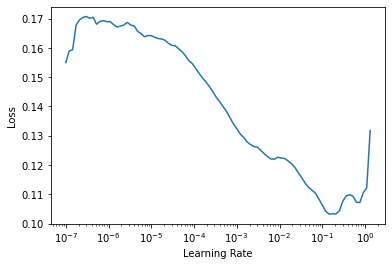

In [12]:
learner.model.noise_mode = True
for param in learner.model.generator.parameters():
    param.requires_grad = True
for param in learner.model.model.parameters():
    param.requires_grad = False
learner.model.noise_mode = True
learner.loss_func.generator_mode = True
learner.lr_find()

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.3630780577659607)

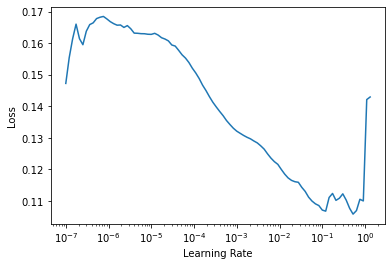

In [13]:
learner.model.noise_mode = False
for param in learner.model.generator.parameters():
    param.requires_grad = False
fb = ["mask","penalty_mask","pos"]
for name, p in learner.model.model.named_parameters(): 
    if name not in fb:
        p.requires_grad_(True)
learner.loss_func.generator_mode = False
learner.lr_find()

In [14]:
learner.fit(2, critic_lr=10-3, generator_lr = 1e-3)

epoch,train_loss,valid_loss,Adversarial_loss,Reconstruction_Loss,Accuracy,time
0,-0.009912,-0.012391,-2.877895,0.001998,0.107237,07:01
0,2.779603,2.812071,-2.812071,0.000000,0.103539,03:07
0,2.606866,2.663392,-2.663392,668.799927,0.088220,04:38
1,0.344554,0.420876,-2.881753,0.435285,0.098785,06:56
1,2.761771,2.927752,-2.927752,0.000000,0.098257,03:07
1,2.644448,2.622326,-2.622326,874.351624,0.098785,04:36


In [12]:
for name, param in learner.model.generator.named_parameters():
    print(name, param.requires_grad)

inc.double_conv.0.weight False
inc.double_conv.0.bias False
inc.double_conv.1.weight False
inc.double_conv.1.bias False
inc.double_conv.3.weight False
inc.double_conv.3.bias False
inc.double_conv.4.weight False
inc.double_conv.4.bias False
down1.maxpool_conv.1.double_conv.0.weight False
down1.maxpool_conv.1.double_conv.0.bias False
down1.maxpool_conv.1.double_conv.1.weight False
down1.maxpool_conv.1.double_conv.1.bias False
down1.maxpool_conv.1.double_conv.3.weight False
down1.maxpool_conv.1.double_conv.3.bias False
down1.maxpool_conv.1.double_conv.4.weight False
down1.maxpool_conv.1.double_conv.4.bias False
down2.maxpool_conv.1.double_conv.0.weight False
down2.maxpool_conv.1.double_conv.0.bias False
down2.maxpool_conv.1.double_conv.1.weight False
down2.maxpool_conv.1.double_conv.1.bias False
down2.maxpool_conv.1.double_conv.3.weight False
down2.maxpool_conv.1.double_conv.3.bias False
down2.maxpool_conv.1.double_conv.4.weight False
down2.maxpool_conv.1.double_conv.4.bias False
down3.ma